🧠 Classical Time Series Models
Great for small datasets or explainability.

1. ARIMA / SARIMA
Univariate

Good for individual customer time series

Doesn't handle multivariate inputs

2. Exponential Smoothing (Holt-Winters)
Good for capturing trends/seasonality

Works best on individual customer series

🧠 Machine Learning Models
Good if you extract features (lags, trends, rolling stats, etc.)

4. Random Forest / Gradient Boosting (e.g., XGBoost, LightGBM)
Treat it like a regression problem

Need feature engineering (lagged values, time of day/week, etc.)

Good for tabular-style learning

5. Linear Regression (with engineered features)
Works better than you'd think if features are well-designed

🧠 Deep Learning Models
Best when lots of data and long-term dependencies matter.

6. LSTM / GRU (Recurrent Neural Networks)
Sequence models, good for capturing temporal dependencies

Can be univariate or multivariate

PyTorch and TensorFlow support these

7. Temporal Convolutional Networks (TCN)
Alternative to RNNs

Often train faster and are easier to tune

8. Transformer-based Models
Powerful for long-range dependencies

Libraries: PyTorch Forecasting, HuggingFace Timeseries Transformers

In [1]:
hyperparameters = {
    "seq_len": 24*7,
    "batch_size": 64,
    "learning_rate": 0.001,
    "num_epochs": 100,
}

In [ ]:
import pandas as pd
import jax.numpy as jnp
import jax
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
from tristan_helpers import *  # Assuming the necessary helper functions are here

# ------------------------------
# 1. Load and prepare the data
# ------------------------------

df = pd.read_csv("data/datasets2025/historical_metering_data_IT.csv", parse_dates=["DATETIME"])
df = df.sort_values("DATETIME")

# Clean the dataset: drop rows with NaN values in the target column
df = df.dropna(axis = 1, how = 'any')  # Drop rows with NaN in the target column
target_col = "VALUEMWHMETERINGDATA_customerIT_54"  #try 53

# Normalize the target column. Split into train and test sets
scaler = MinMaxScaler(feature_range=(0, 1))
test_size = 31 * 24  # 30 days * 24 hours = 720 hours
train_array = scaler.fit_transform(df[[target_col]].values[:-test_size])
test_array = df[[target_col]].values[-test_size:]
# train_data = df[:-test_size]
# test_data = df[-test_size:]

# ------------------------------
# 2. Create Dataset Class
# ------------------------------

# Create DataLoader for training
seq_len = hyperparameters["seq_len"]
train_dataset = TimeSeriesDataset(train_array, seq_len=seq_len)
train_loader = DataLoader(train_dataset, batch_size=hyperparameters["batch_size"], shuffle=True)

# x,y = next(iter(train_loader))
# print(f"X shape: {x.shape}, Y shape: {y.shape}")

# ------------------------------
# 3. Define LSTM Model
# ------------------------------

# Set device to CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = LSTMForecast().to(device)
# model = TimeSeriesTransformer(seq_len=seq_len).to(device)  # Use the transformer model
model = TCNForecast(input_dim=1).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters["learning_rate"])

# ------------------------------
# 4. Training Loop
# ------------------------------

# Training loop with progress bar
progress_bar = tqdm(range(hyperparameters["num_epochs"]), desc="Training Epochs")
epoch_losses = []
for epoch in progress_bar:
    model.train()
    total_loss = 0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)  # Move data to GPU
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    progress_bar.set_postfix(loss=f"{avg_loss:.5f}")

# Save the trained model
model_path = "saved_models/lstm_forecast.pt"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# ------------------------------
# 5. Plot the Loss
# ------------------------------

plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label="Training Loss", color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Training Epochs:  93%|█████████▎| 93/100 [05:50<00:26,  3.74s/it, loss=0.00216]

Total predictions to evaluate: 576 (does include skipped indices because of zero actual values)
[array([0.5311603]), array([0.59213877]), array([0.34662887]), array([0.63084594]), array([0.76560397]), array([0.63224204]), array([0.25291309]), array([0.39069319]), array([0.09759647]), array([0.6776866]), array([0.39847878]), array([0.16469265]), array([0.41613918]), array([0.27635318]), array([0.6180347]), array([0.95939523]), array([0.43300377]), array([0.10481056]), array([0.69340834]), array([0.26167217]), array([0.38231941]), array([0.47521447]), array([0.41183295]), array([0.01161441]), array([0.21388951]), array([0.52679781]), array([0.32814673]), array([0.37333332]), array([0.40120916]), array([0.53492156]), array([0.49817085]), array([0.36909561]), array([0.54525765]), array([0.30570753]), array([0.56241551]), array([0.36325656]), array([0.50599683]), array([0.29334879]), array([0.38526111]), array([0.3752396]), array([0.71839082]), array([0.35360362]), array([0.42988873]), arra

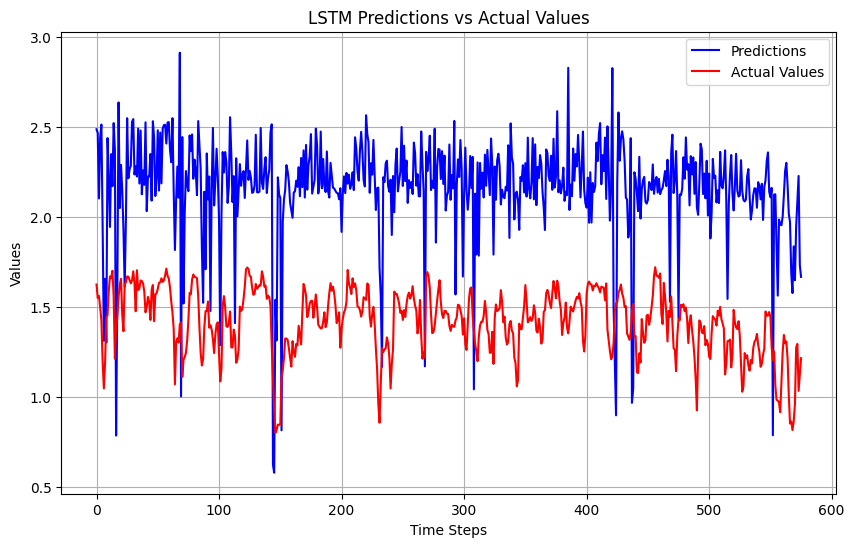

In [6]:
# ------------------------------
# 6. Evaluation
# ------------------------------

model_path = "saved_models/lstm_forecast.pt"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

# Switch model to evaluation mode
model.eval()

rel_error = []
total_predictions = len(test_array) - seq_len
print(f"Total predictions to evaluate: {total_predictions} (does include skipped indices because of zero actual values)")
skipped_indices = 0
not_skipped_indices = 0
predictions = []
actual_values = []

for idx in range(seq_len, len(test_array)):  # Start from seq_len because we need previous data for prediction
    last_seq = torch.tensor(test_array[idx-seq_len:idx], dtype=torch.float32).to(device)
    actual_value = test_array[idx]
    actual_values.append(actual_value)
    # Handle division by zero
    if actual_value != 0:
        with torch.no_grad():
            pred = model(last_seq.unsqueeze(0))  # Make the prediction
            
            # Move tensor to CPU and reshape for inverse scaling
            pred_rescaled = scaler.inverse_transform(pred.cpu().unsqueeze(0).reshape(-1, 1))
            predictions.append(pred_rescaled[0][0])

        rel_error.append(abs((pred_rescaled[0][0] - actual_value)/ actual_value))
        not_skipped_indices += 1
        
    else:
        skipped_indices += 1
        continue

accuracy = jnp.mean(jnp.array(rel_error))
print(rel_error)
print(f"Model accuracy: {accuracy:.2f}%")
print(f"Percentage of skipped indices due to zero actual value: {skipped_indices/(skipped_indices + not_skipped_indices)*100:.2f}%")

# plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(predictions, label="Predictions", color='blue')
plt.plot(actual_values, label="Actual Values", color='red')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('LSTM Predictions vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

JAX version

In [ ]:
import pandas as pd
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# ------------------------------
# 1. Load and prepare the data
# ------------------------------

df = pd.read_csv("data/datasets2025/historical_metering_data_IT.csv", parse_dates=["DATETIME"])
df = df.sort_values("DATETIME")

# Create a new DataFrame where no columns have any NaN values
df = df.dropna(axis=1, how='any')

# Choose ONE customer for now (e.g., customerES_1)
target_col = "VALUEMWHMETERINGDATA_customerIT_6"
series = df[["DATETIME", target_col]].dropna()

scaler = MinMaxScaler(feature_range=(0, 1))
# Normalize target values
series["value"] = scaler.fit_transform(series[[target_col]])

# Split Data (Train/Test)
# Define test size as the last month's data
test_size = 30 * 24  # 30 days * 24 hours = 720 hours

# Split dataset
train_data = series[:-test_size]  # All data except the last month's data
test_data = series[-test_size:]  # Last month's data

# ------------------------------
# 2. Create Dataset for Multi-Step Forecasting
# ------------------------------

class TimeSeriesDataset:
    def __init__(self, series, seq_len=24, forecast_horizon=3):
        self.seq_len = seq_len
        self.forecast_horizon = forecast_horizon
        self.data = series["value"].values

    def __len__(self):
        return len(self.data) - self.seq_len - self.forecast_horizon

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_len]  # these are the input features
        y = self.data[idx + self.seq_len:idx + self.seq_len + self.forecast_horizon]  # target sequence to predict
        return x, y

seq_len = 24  # e.g., using 24 hours of history to predict the next hours
forecast_horizon = 3  # Predicting the next 3 hours
train_dataset = TimeSeriesDataset(train_data, seq_len=seq_len, forecast_horizon=forecast_horizon)
test_dataset = TimeSeriesDataset(test_data, seq_len=seq_len, forecast_horizon=forecast_horizon)

# ------------------------------
# 3. Define LSTM Model in Flax (For Multi-Step)
# ------------------------------

class LSTMForecast(nn.Module):
    hidden_dim: int
    forecast_horizon: int
    
    def setup(self):
        # Layers of the LSTM network
        self.lstm_cell = nn.LSTMCell(name="lstm_cell")
        self.dense = nn.Dense(self.forecast_horizon)

    def __call__(self, x):
        batch_size = x.shape[0]
        state = self.lstm_cell.initialize_carry(jax.random.PRNGKey(0), batch_size, x.shape[1])
        outputs = []
        
        for t in range(x.shape[1]):
            state, _ = self.lstm_cell(state, x[:, t])
            outputs.append(state[0])
        
        output = jnp.stack(outputs, axis=1)
        return self.dense(output[:, -1])  # Only take the last output from LSTM

# ------------------------------
# 4. Loss Function and Gradients (for Multi-Step)
# ------------------------------

def loss_fn(params, model, x, y):
    pred = model.apply({"params": params}, x)
    return jnp.mean((pred - y) ** 2)  # MSE loss

grad_loss_fn = jax.value_and_grad(loss_fn)

# ------------------------------
# 5. Training Loop with JAX and Flax (for Multi-Step)
# ------------------------------

# Initialize parameters
model = LSTMForecast(hidden_dim=64, forecast_horizon=forecast_horizon)
params = model.init(jax.random.PRNGKey(0), jnp.ones((1, seq_len)))  # Initialize model

# Optimizer (using optax)
optimizer = optax.adam(learning_rate=0.001)
opt_state = optimizer.init(params)

# Training loop
epochs = 500
progress_bar = tqdm(range(epochs), desc="Training Epochs")

for epoch in progress_bar:
    total_loss = 0
    for idx in range(len(train_dataset)):
        x, y = train_dataset[idx]

        # Convert data to JAX arrays and reshape as needed
        x = jnp.array(x).reshape(1, seq_len)
        y = jnp.array(y).reshape(1, forecast_horizon)

        # Compute loss and gradients
        loss, grads = grad_loss_fn(params, model, x, y)

        # Update the parameters
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)

        total_loss += loss

    # Update the progress bar
    avg_loss = total_loss / len(train_dataset)
    progress_bar.set_postfix(loss=f"{avg_loss:.5f}")

# ------------------------------
# 6. Evaluation for Multi-Step Forecasting
# ------------------------------

# Define accuracy threshold (e.g., 5%)
threshold = 0.05  # 5% accuracy threshold

accurate_predictions = 0
total_predictions = len(test_dataset)

for idx in range(len(test_dataset)):
    x, y = test_dataset[idx]

    # Convert data to JAX arrays and reshape as needed
    x = jnp.array(x).reshape(1, seq_len)
    y = jnp.array(y).reshape(1, forecast_horizon)

    # Make multi-step prediction
    pred = model.apply({"params": params}, x)
    
    # Rescale prediction and true value
    pred_rescaled = scaler.inverse_transform(pred.reshape(-1, 1))  # Rescale the prediction
    actual_rescaled = scaler.inverse_transform(y.reshape(-1, 1))  # Rescale the actual value
    
    # Calculate error for each forecasted step
    error = jnp.abs(pred_rescaled - actual_rescaled)

    # Check if each of the forecasted steps is within the accuracy threshold
    for i in range(forecast_horizon):
        if error[i] / actual_rescaled[i] <= threshold:
            accurate_predictions += 1

# Calculate accuracy
accuracy = (accurate_predictions / total_predictions) * 100
print(f"Model accuracy: {accuracy:.2f}%")
